In [ ]:
#Conda 환경 설정
!conda create -n convert
!conda activate convert
!conda install jupyter notebook
!python3 -m ipykernel install --user --name convert --display-name "convert"

In [ ]:
#update
!sudo apt update --yes
!sudo apt upgrade --yes
!sudo apt autoremove --yes

In [ ]:
#lib 설치
!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
!conda install -c conda-forge onnx

In [ ]:
%cd /home/ai/Desktop/work/ai_boostcamp/final/pth_convert

Pytorch를 ONNX로 변환

In [1]:
import torch
import onnx
#https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py

#customized model
from models.deeplabv3 import deeplabv3_mobilenet_v3

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_model = deeplabv3_mobilenet_v3(
    pretrained_backbone=False,
    aux_loss=False,
    small=True,
    reduced_tail=True,
    grid_mode=True,
).to(device)

model_path = '../../p_stage_img_seg/baseline_dev/model_weights_aux_reduced.ptbb_adamw.140.pth'
tmp = torch.load(model_path)
for w_name in list(tmp.keys())[-8:]:
    del tmp[w_name]
torch_model.load_state_dict(tmp)

# torch_model.load_state_dict(torch.load(model_path))
torch_model.eval()

batch_size = 1
x = torch.randn(batch_size, 3, 240, 320).to(device)

# 모델 변환
torch.onnx.export(torch_model,               # 실행될 모델
                  x,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "onnx.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부 default True
                  opset_version=10,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적하시 상수폴딩을 사용할지의 여부 Default False
                  verbose = True,
                  input_names = ['actual_input_1'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output1'] # 모델의 출력값을 가리키는 이름
                  )
onnx_model = onnx.load("onnx.onnx")
onnx.checker.check_model(onnx_model)
onnx.helper.printable_graph(onnx_model.graph)

/opt/conda/envs/opt-py39/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:381: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "


graph(%actual_input_1 : Float(1, 3, 240, 320, strides=[230400, 76800, 320, 1], requires_grad=0, device=cuda:0),
      %backbone.1.block.1.fc1.weight : Float(8, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.1.block.1.fc1.bias : Float(8, strides=[1], requires_grad=1, device=cuda:0),
      %backbone.1.block.1.fc2.weight : Float(16, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.1.block.1.fc2.bias : Float(16, strides=[1], requires_grad=1, device=cuda:0),
      %backbone.4.block.2.fc1.weight : Float(24, 96, 1, 1, strides=[96, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.4.block.2.fc1.bias : Float(24, strides=[1], requires_grad=1, device=cuda:0),
      %backbone.4.block.2.fc2.weight : Float(96, 24, 1, 1, strides=[24, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.4.block.2.fc2.bias : Float(96, strides=[1], requires_grad=1, device=cuda:0),
      %backbone.5.block.2.fc1.weight : Float(64, 240, 1, 1, 

"graph torch-jit-export (\n  %actual_input_1[FLOAT, 1x3x240x320]\n) initializers (\n  %backbone.1.block.1.fc1.weight[FLOAT, 8x16x1x1]\n  %backbone.1.block.1.fc1.bias[FLOAT, 8]\n  %backbone.1.block.1.fc2.weight[FLOAT, 16x8x1x1]\n  %backbone.1.block.1.fc2.bias[FLOAT, 16]\n  %backbone.4.block.2.fc1.weight[FLOAT, 24x96x1x1]\n  %backbone.4.block.2.fc1.bias[FLOAT, 24]\n  %backbone.4.block.2.fc2.weight[FLOAT, 96x24x1x1]\n  %backbone.4.block.2.fc2.bias[FLOAT, 96]\n  %backbone.5.block.2.fc1.weight[FLOAT, 64x240x1x1]\n  %backbone.5.block.2.fc1.bias[FLOAT, 64]\n  %backbone.5.block.2.fc2.weight[FLOAT, 240x64x1x1]\n  %backbone.5.block.2.fc2.bias[FLOAT, 240]\n  %backbone.6.block.2.fc1.weight[FLOAT, 64x240x1x1]\n  %backbone.6.block.2.fc1.bias[FLOAT, 64]\n  %backbone.6.block.2.fc2.weight[FLOAT, 240x64x1x1]\n  %backbone.6.block.2.fc2.bias[FLOAT, 240]\n  %backbone.7.block.2.fc1.weight[FLOAT, 32x120x1x1]\n  %backbone.7.block.2.fc1.bias[FLOAT, 32]\n  %backbone.7.block.2.fc2.weight[FLOAT, 120x32x1x1]\n  %b

ONNX를 TensorFlow로 변환

In [ ]:
!pip install onnx_tf
!sudo apt update --yes
!sudo apt install python3-dev python3-pip python3-venv --yes
!pip install --upgrade tensorflow

In [2]:
from onnx_tf.backend import prepare
import onnx

TF_PATH = "./pb.pb" # where the representation of tensorflow model will be stored
ONNX_PATH = "./onnx.onnx" # path to my existing ONNX model
onnx_model = onnx.load(ONNX_PATH)  # load onnx model

tf_rep = prepare(onnx_model)  # creating TensorflowRep object

tf_rep.export_graph(TF_PATH)

2021-12-22 16:37:33.682910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 16:37:33.682961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-22 16:37:35.819786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 16:37:35.820944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 16:37:35.821002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

INFO:tensorflow:Assets written to: ./pb.pb/assets


INFO:tensorflow:Assets written to: ./pb.pb/assets


TensorFlow를 TensorFlow Lite로 변환

In [3]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("./pb.pb") # path to the SavedModel directory

#optimization
#https://github.com/sithu31296/PyTorch-ONNX-TFLite
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#https://www.tensorflow.org/lite/performance/post_training_quantization?hl=ko
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TF ops
]
tflite_model = converter.convert()

# Save the model.
with open('tflite.tflite', 'wb') as f:
  f.write(tflite_model)

2021-12-22 16:37:48.744351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-22 16:37:48.744419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-22 16:37:48.744428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2021-12-22 16:37:48.745882: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./pb.pb
2021-12-22 16:37:48.761994: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-22 16:37:48.762096: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: ./pb.pb
2021-12-22 16:37:48.794516: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-22 16:37:49.113364: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: ./pb.pb
2021-12-22 16:37:49.304987: I

Estimated count of arithmetic ops: 1.980 G  ops, equivalently 0.990 G  MACs


torch.Size([1, 3, 240, 320])
(240, 320, 3)


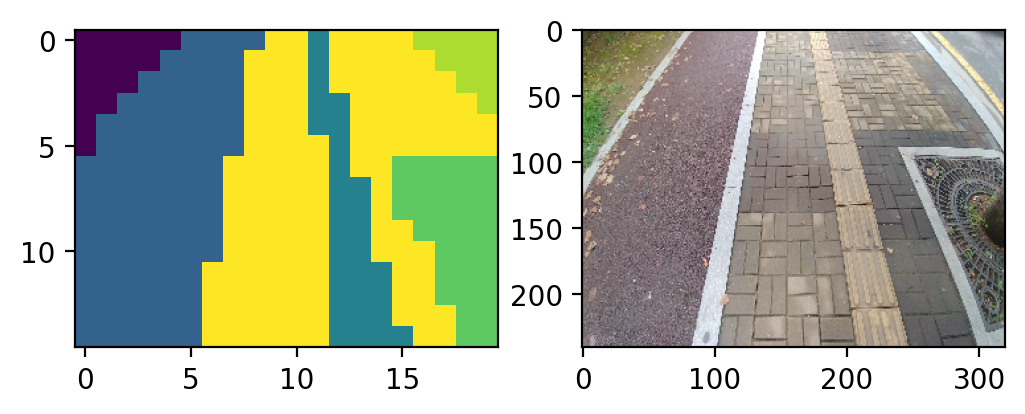

In [5]:
import numpy as np
import tensorflow as tf
from PIL import Image 
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

filename = './test_images/MP_SEL_SUR_000004.jpg'

#transfom compose 방법
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
])
input_data = preprocess(input_image)
input_data = input_data.unsqueeze(0) # create a mini-batch as expected by the model


print(input_data.size())

#albumnetations 방법
# input_image = plt.imread(filename)
# transform = A.Compose([
#     A.Resize(240, 320),
#     A.Normalize(),
#     ToTensorV2()
# ])

# transformed = transform(image=input_image)
# input_data = transformed['image'].unsqueeze(0)

interpreter = tf.lite.Interpreter(model_path='tflite.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = output_data.argmax(1)
input_data = input_data[0].cpu().numpy().transpose([1, 2, 0])
print(input_data.shape)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#input_data = input_data * (std) + (mean)
#input_data = torch.Tensor(input_data)
#input_data.mul_(torch.tensor(std)).add_(torch.tensor(mean))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, dpi=200)
axes[0].imshow(output_data[0])
axes[1].imshow(input_data)